In [ ]:
!pip install pennylane



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 50.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 61.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd

# Read the CSV file
df = pd.read_csv("in2.csv")

# Display the range of values in each column
for column in df.columns:
    min_val = df[column].min()
    max_val = df[column].max()
    print(f"Column '{column}' has values ranging from {min_val} to {max_val}")


Column 'nodenumber' has values ranging from 1 to 216592
Column 'x-coordinate' has values ranging from -0.04380681366 to 0.01545021031
Column 'y-coordinate' has values ranging from -0.01490026154 to 0.09935382009
Column 'z-coordinate' has values ranging from -0.08758345991 to 0.08575088531
Column 'total-pressure' has values ranging from -44691.56641 to 64015.29688
Column 'velocity-magnitude' has values ranging from 0.0 to 11.7817049
Column 'x-velocity' has values ranging from -5.856424809 to 5.439496517
Column 'y-velocity' has values ranging from -3.8142066 to 11.1477356
Column 'z-velocity' has values ranging from -7.006043434 to 11.47185516
Column 'wall-shear' has values ranging from 0.0 to 2129.567383
Column 'x-wall-shear' has values ranging from -1440.150513 to 1288.060547
Column 'y-wall-shear' has values ranging from -1159.226685 to 2098.739258
Column 'z-wall-shear' has values ranging from -1354.746826 to 1130.613281


In [ ]:
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor

def quantum_forest_circuit(params, x):
    # Quantum circuit definition using PennyLane
    for i in range(len(x)):
        qml.RX(params[i, 0], wires=i)
        qml.RY(params[i, 1], wires=i)

    qml.broadcast(unitary=qml.CNOT, pattern="ring", wires=range(len(x)))

    # Measurement on each qubit
    measurements = [qml.expval(qml.PauliZ(wires=i)) for i in range(len(x))]

    return measurements

params = np.random.rand(12, 2)


qml.draw_mpl(quantum_forest_circuit)

<function __main__.quantum_forest_circuit(params, x)>

In [ ]:
import pandas as pd
import pennylane as qml
from pennylane import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor


# Load data
data = pd.read_csv("in3.csv")
y = data["velocity-magnitude"]
X = data.drop(columns=["wall-shear", "x-wall-shear", "y-wall-shear", "z-wall-shear", "velocity-magnitude"], axis=1)

# Select features and target variable
# Normalize features
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)
# Normalize features
# scaler = StandardScaler()
# X_normalized = scaler.fit_transform(X)

# Split the dataset into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.2, random_state=42)

def quantum_forest_circuit(params, x):
    # Quantum circuit definition using PennyLane
    for i in range(len(x)):
        qml.RX(params[i, 0], wires=i)
        qml.RY(params[i, 1], wires=i)

    qml.broadcast(unitary=qml.CNOT, pattern="ring", wires=range(len(x)))

    # Measurement on each qubit
    measurements = [qml.expval(qml.PauliZ(wires=i)) for i in range(len(x))]

    return measurements

params = np.random.rand(len(X.columns), 2)

# Set up the PennyLane quantum device and create the quantum node
device_arn = "arn:aws:braket:::device/quantum-simulator/amazon/sv1"
dev = qml.device("default.qubit", wires=len(X.columns))
qml_circuit = qml.QNode(quantum_forest_circuit, dev)

# Define the quantum function to predict
def quantum_forest_predict(params, x):
    return np.array(qml_circuit(params, x))

# Apply the quantum circuit to the normalized training and testing data
X_train_qml = np.array([quantum_forest_predict(params, x) for x in X_train])
X_test_qml = np.array([quantum_forest_predict(params, x) for x in X_test])

# print(quantum_forest_circuit.draw())




In [ ]:
print("Minimum values of normalized data:")
print(np.min(X_normalized, axis=0))

print("\nMaximum values of normalized data:")
print(np.max(X_normalized-9, axis=0))

Minimum values of normalized data:
[-1.73204281 -2.83298188 -2.60360652 -2.39727165 -4.90219971 -7.49564682
 -2.00462097 -2.60480147]

Maximum values of normalized data:
[1.73204281 1.88082318 2.58136896 1.8203788  1.97812354 7.29890282
 4.39087656 4.22639034]


In [ ]:
# Initialize the classical Random Forest Regressor
qrf_model = RandomForestRegressor()

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [300, 500, 800, 1000, 1200],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
# grid_search = GridSearchCV(qrf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the data
qrf_model.fit(X_train_qml, y_train)

# Get the best model from the grid search
# best_model = grid_search.best_estimator_

# Make predictions on the testing data using the best model
y_pred = qrf_model.predict(X_test_qml)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# print(f'Best Model Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse}')

df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Print a sample of the first 5 rows (or adjust the number as needed)
print(df.head())


Mean Squared Error: 6.399106592154766
         Actual  Predicted
51404  0.184489   2.527824
89955  0.000000   2.527824
95246  0.209936   2.527824
90910  0.247161   2.527824
77941  0.178004   2.527824


Mean Squared Error: 6.508403167039035


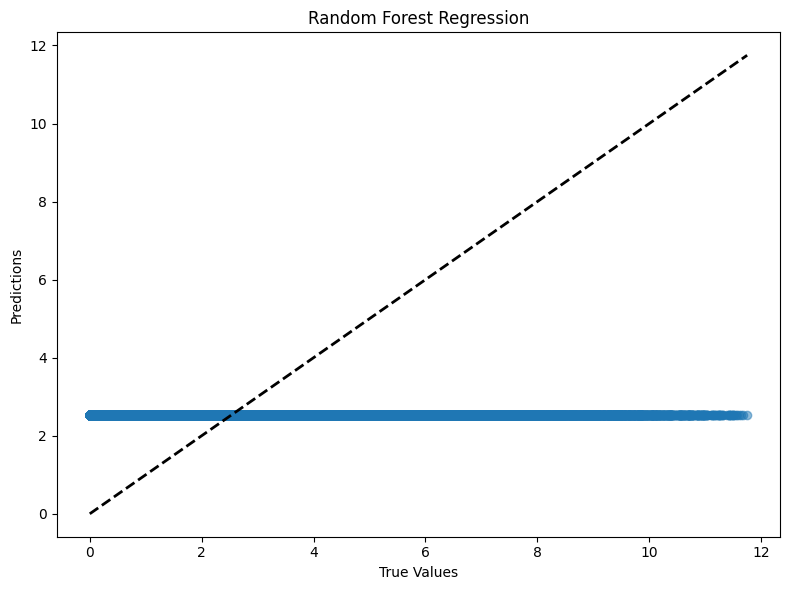

In [ ]:
import matplotlib.pyplot as plt
# Initialize the classical Random Forest Regressor
qrf_model = RandomForestRegressor(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [300, 500, 800, 1000, 1200],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
# grid_search = GridSearchCV(qrf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the data
qrf_model.fit(X_train_qml, y_train)

# Get the best model from the grid search
# best_model = grid_search.best_estimator_

# Make predictions on the testing data using the best model
y_pred = qrf_model.predict(X_test_qml)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# print(f'Best Model Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse}')


plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Random Forest Regression')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.tight_layout()
plt.show()


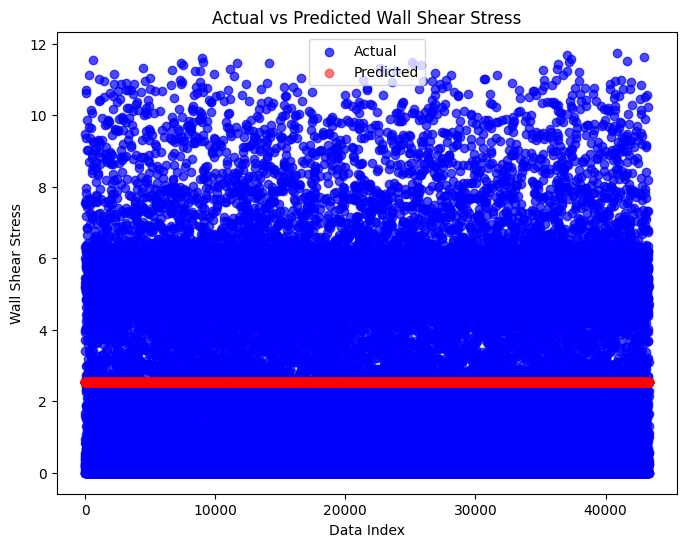

In [ ]:
plt.figure(figsize=(8, 6))

# Plotting actual values in blue
plt.scatter(range(len(y_test)), y_test, color='blue', label='Actual', alpha=0.7)

# Plotting predicted values in red
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted', alpha=0.5)

plt.xlabel('Data Index')
plt.ylabel('Wall Shear Stress')
plt.title('Actual vs Predicted Wall Shear Stress')
plt.legend()
plt.show()

DTR - Mean Squared Error (MSE): 6.399089095634998
DTR - R-squared (R2): -0.00014147949232468093


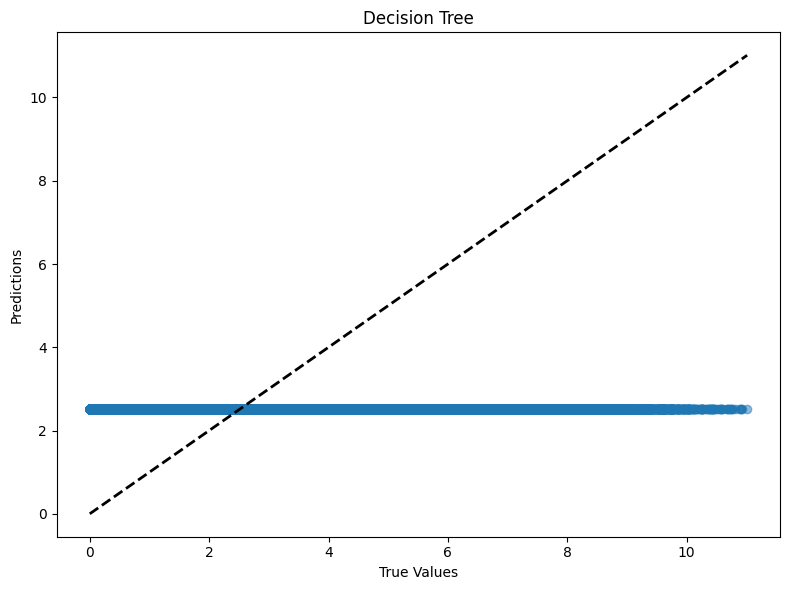

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initialize the classical DECISION TREE
dtr = DecisionTreeRegressor(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [300, 500, 800, 1000, 1200],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
# grid_search = GridSearchCV(qrf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the data
dtr.fit(X_train_qml, y_train)

# Get the best model from the grid search
# best_model = grid_search.best_estimator_

# Make predictions on the testing data using the best model
y_pred_dt = dtr.predict(X_test_qml)

# Calculate the Mean Squared Error
mse_dtr = mean_squared_error(y_test, y_pred_dt)
r2_dtr = r2_score(y_test, y_pred_dt)

# print(f'Best Model Parameters: {grid_search.best_params_}')
print(f"DTR - Mean Squared Error (MSE): {mse_dtr}")
print(f"DTR - R-squared (R2): {r2_dtr}")



plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred_dt, alpha=0.5)
plt.title('Decision Tree')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
# Initialize the classical DECISION TREE
qrf_model = DecisionTreeRegressor(random_state=42)

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [300, 500, 800, 1000, 1200],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the GridSearchCV object
# grid_search = GridSearchCV(qrf_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the GridSearchCV object to the data
qrf_model.fit(X_train_qml, y_train)

# Get the best model from the grid search
# best_model = grid_search.best_estimator_

# Make predictions on the testing data using the best model
y_pred = qrf_model.predict(X_test_qml)

# Calculate the Mean Squared Error
mse = mean_squared_error(y_test, y_pred)

# print(f'Best Model Parameters: {grid_search.best_params_}')
print(f'Mean Squared Error: {mse}')


plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred, alpha=0.5)
plt.title('Decision Tree')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.tight_layout()
plt.show()


NameError: name 'DecisionTreeRegressor' is not defined

Gradient Boosting Machine - Mean Squared Error (MSE): 0.03982313161702207
Gradient Boosting Machine - R-squared (R2): 0.9937758694748234


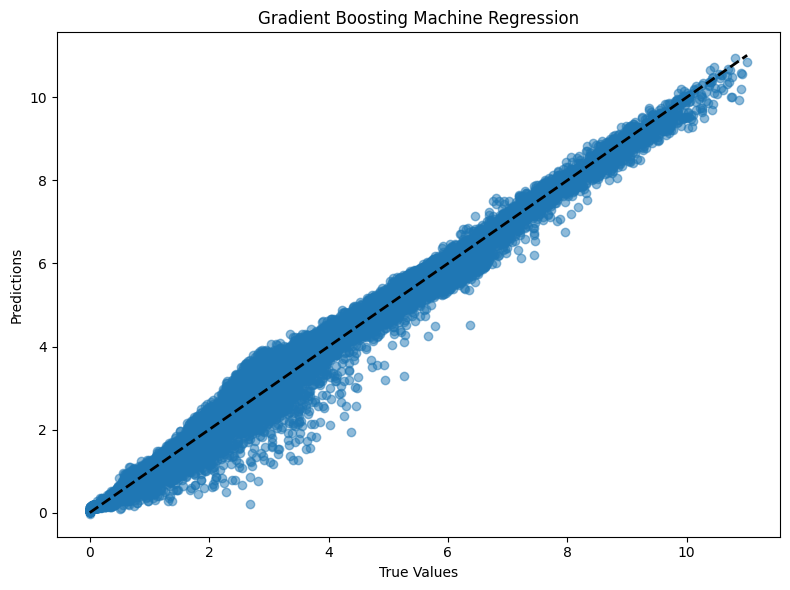

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Initialize GradientBoostingRegressor
gbm = GradientBoostingRegressor(random_state=42)

# Train the model
gbm.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gbm = gbm.predict(X_test)

# Evaluate the model
mse_gbm = mean_squared_error(y_test, y_pred_gbm)
r2_gbm = r2_score(y_test, y_pred_gbm)

print(f"Gradient Boosting Machine - Mean Squared Error (MSE): {mse_gbm}")
print(f"Gradient Boosting Machine - R-squared (R2): {r2_gbm}")

# Plotting the regression plot
plt.figure(figsize=(8, 6))

plt.scatter(y_test, y_pred_gbm, alpha=0.5)
plt.title('Gradient Boosting Machine Regression')
plt.xlabel('True Values')
plt.ylabel('Predictions')

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.tight_layout()
plt.show()


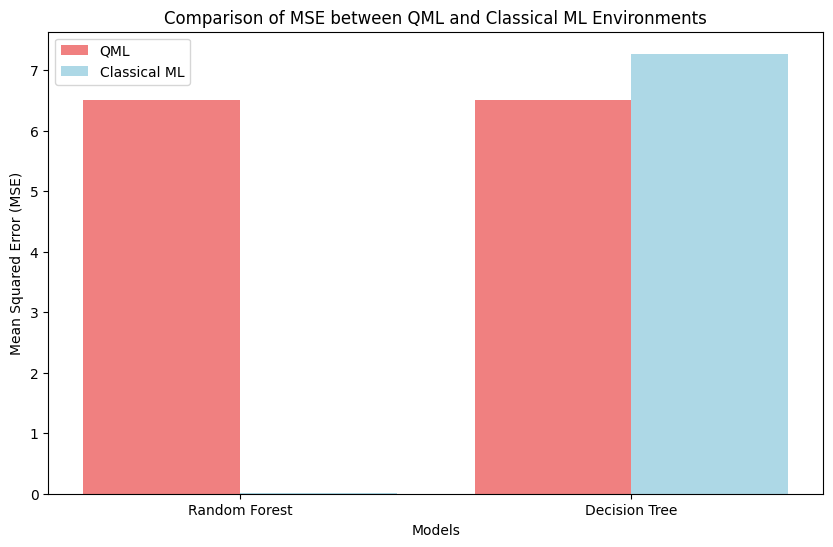

In [ ]:
import matplotlib.pyplot as plt

# Mean Squared Error (MSE) values for Random Forest and Decision Tree models in QML and Classical ML environments
# Replace these with your actual MSE values
mse_qml_rf = 6.5084  # MSE of Random Forest in QML environment
mse_classical_rf = 0.0105  # MSE of Random Forest in Classical ML environment
mse_qml_dt = 6.5085  # MSE of Decision Tree in QML environment
mse_classical_dt = 0.02317  # MSE of Decision Tree in Classical ML environment

# Plotting the MSE values
models = ['Random Forest', 'Decision Tree']
environments = ['QML', 'Classical ML']
qml_mse_values = [mse_qml_rf, mse_qml_dt]
classical_mse_values = [mse_classical_rf, mse_classical_dt]

plt.figure(figsize=(10, 6))

plt.bar([0.8, 1.8], qml_mse_values, width=0.4, label='QML', color='lightcoral', align='center')
plt.bar([1.2, 2.2], classical_mse_values, width=0.4, label='Classical ML', color='lightblue', align='center')

plt.xlabel('Models')
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Comparison of MSE between QML and Classical ML Environments')
plt.xticks([1, 2], models)
plt.legend()

plt.show()
